# Entropy and Schmidt Spectrum Decomposition Analysis

USE mps_env1

In [1]:
from mpsprep import MatrixProductState, MatrixProductInitializer
from mpsprep.helpers import (
    mean_fractional_entropy, coarse_truncate_s_vals,
    ranks_from_s_vals, state_fidelity,
    best_s_val_truncation_idx, 
    truncate_s_vals, generate_target_state,
)

import numpy as np
import matplotlib.pyplot as plt

Functionality to Compute Entropies

In [5]:
def mean_fractional_entropy(y_amp):
    """
    Given an array of amplitudes y_amp that define the quantum state
    :math:`|y> = \\sum_i y_{amp}[i] |i>`, this function returns the mean
    fractional entropy of :math:`|y>`.

    Parameters
    ----------
    y_amp : np.ndarray
        Array of amplitudes. Can be complex.

    Returns
    -------
    mean_fractional_entropy : float
        Mean fractional entropy of the amplitudes.
    """
    assert len(y_amp.shape) == 1, "y_amp should be 1-D."
    num_qubits = np.log2(y_amp.shape[0])
    assert np.round(num_qubits) == int(num_qubits), "len(y_amp) should be 2^N."
    num_qubits = int(num_qubits)

    entropies = np.zeros((num_qubits - 1))
    frac_entropies = np.zeros((num_qubits - 1))
    for bond in range(num_qubits - 1):
        yamp_unfolded = np.reshape(y_amp, (2**(bond + 1), -1), "C")
        qubits_A = bond + 1
        qubits_B = num_qubits - qubits_A
        qubits = min(qubits_A, qubits_B)
        maximal_entropy = qubits
        s = np.linalg.svd(yamp_unfolded, compute_uv=False)
        s2 = np.abs(s)**2
        nonzero_mask = s2 != 0
        temp = np.zeros(s2.shape)
        temp[nonzero_mask] = s2[nonzero_mask]*np.log2(s2[nonzero_mask])
        entropies[bond] = -np.sum(temp)
        frac_entropies[bond] = entropies[bond]/maximal_entropy

    mean_frac_entropy = np.mean(frac_entropies)
    return mean_frac_entropy


def central_fractional_entropy(y_amp):
    """
    Given an array of amplitudes y_amp that define the quantum state
    :math:`|y> = \\sum_i y_{amp}[i] |i>`, this function returns the
    fractional entropy of the central bipartition of :math:`|y>`.

    Parameters
    ----------
    y_amp : np.ndarray
        Array of amplitudes. Can be complex.

    Returns
    -------
    fractional_entropy : float
        Fractional entropy of the central bipartition of the amplitudes.
    """
    # Validate input is a 1-D array
    assert y_amp.ndim == 1, "y_amp should be a 1-D array."

    # Calculate number of qubits
    num_qubits = np.log2(y_amp.shape[0])
    assert np.isclose(num_qubits, int(num_qubits)), "Length of y_amp should be a power of 2."
    num_qubits = int(num_qubits)

    # Ensure the number of qubits is even
    assert num_qubits % 2 == 0, "Number of qubits must be even."

    # Define the central bipartition
    central_bond = num_qubits // 2  # Split after central_bond qubits

    # Reshape the amplitude array to separate the two halves
    yamp_unfolded = np.reshape(y_amp, (2**central_bond, 2**central_bond), order='C')

    # Compute Schmidt coefficients via Singular Value Decomposition (SVD)
    singular_values = np.linalg.svd(yamp_unfolded, compute_uv=False)
    s_squared = np.abs(singular_values)**2

    # Filter out zero singular values to avoid log2(0)
    nonzero_mask = s_squared > 0
    s_squared = s_squared[nonzero_mask]

    # Compute von Neumann entropy
    entropy = -np.sum(s_squared * np.log2(s_squared))

    # Calculate maximal entropy for the central bipartition
    # Since the bipartition is equal, maximal entropy is the number of qubits in one subsystem
    maximal_entropy = central_bond

    # Compute fractional entropy
    fractional_entropy = entropy / maximal_entropy

    return fractional_entropy

def central_entropy(y_amp):
    """
    Given an array of amplitudes y_amp that define the quantum state
    :math:`|y> = \\sum_i y_{amp}[i] |i>`, this function returns the
    fractional entropy of the central bipartition of :math:`|y>`.

    Parameters
    ----------
    y_amp : np.ndarray
        Array of amplitudes. Can be complex.

    Returns
    -------
    fractional_entropy : float
        Fractional entropy of the central bipartition of the amplitudes.
    """
    # Validate input is a 1-D array
    assert y_amp.ndim == 1, "y_amp should be a 1-D array."

    # Calculate number of qubits
    num_qubits = np.log2(y_amp.shape[0])
    assert np.isclose(num_qubits, int(num_qubits)), "Length of y_amp should be a power of 2."
    num_qubits = int(num_qubits)

    # Ensure the number of qubits is even
    assert num_qubits % 2 == 0, "Number of qubits must be even."

    # Define the central bipartition
    central_bond = num_qubits // 2  # Split after central_bond qubits

    # Reshape the amplitude array to separate the two halves
    yamp_unfolded = np.reshape(y_amp, (2**central_bond, 2**central_bond), order='C')

    # Compute Schmidt coefficients via Singular Value Decomposition (SVD)
    singular_values = np.linalg.svd(yamp_unfolded, compute_uv=False)
    s_squared = np.abs(singular_values)**2

    # Filter out zero singular values to avoid log2(0)
    nonzero_mask = s_squared > 0
    s_squared = s_squared[nonzero_mask]

    # Compute von Neumann entropy
    entropy = -np.sum(s_squared * np.log2(s_squared))

    return entropy

def weighted_total_entropy(y_amp):
    """
    Given an array of amplitudes y_amp that define the quantum state
    :math:`|y> = \\sum_i y_{amp}[i] |i>`, this function returns the weighted
    total entropy of :math:`|y>` by dividing the sum of entropies across all
    bipartitions by the maximum possible total entropy.

    Parameters
    ----------
    y_amp : np.ndarray
        Array of amplitudes. Can be complex.

    Returns
    -------
    weighted_total_entropy : float
        Weighted total entropy of the amplitudes, normalized by the maximum possible total entropy.
    """
    assert len(y_amp.shape) == 1, "y_amp should be 1-D."
    num_qubits = np.log2(y_amp.shape[0])
    assert np.round(num_qubits) == int(num_qubits), "len(y_amp) should be 2^N."
    num_qubits = int(num_qubits)

    total_entropy = 0.0
    max_total_entropy = 0.0

    for bond in range(num_qubits - 1):
        # Reshape the amplitude array to separate the bipartition
        yamp_unfolded = np.reshape(y_amp, (2**(bond + 1), -1), order='C')
        
        # Determine the number of qubits on each side of the bipartition
        qubits_A = bond + 1
        qubits_B = num_qubits - qubits_A
        qubits = min(qubits_A, qubits_B)
        maximal_entropy = qubits  # Maximum entropy for this bipartition

        # Compute the singular values from the reshaped amplitude matrix
        s = np.linalg.svd(yamp_unfolded, compute_uv=False)
        s2 = np.abs(s)**2

        # Calculate the von Neumann entropy for this bipartition
        nonzero_mask = s2 > 0
        entropy = -np.sum(s2[nonzero_mask] * np.log2(s2[nonzero_mask]))
        total_entropy += entropy
        max_total_entropy += maximal_entropy

    # Compute the weighted total entropy
    weighted_total_entropy = total_entropy / max_total_entropy if max_total_entropy > 0 else 0.0
    return weighted_total_entropy

def generate_random_n_qubit_state(n):
    """
    Generates a random quantum state vector for an n-qubit system.

    Parameters:
    - n (int): Number of qubits.

    Returns:
    - state_vector (numpy.ndarray): A 1D complex numpy array of length 2^n representing the quantum state.
    """

    dimension = 2 ** n  # Dimension of the Hilbert space for n qubits

    # Generate random real and imaginary parts from a normal distribution
    real_parts = np.random.normal(0, 1, dimension)
    #imag_parts = np.random.normal(0, 1, dimension)
    random_vector = real_parts #+ 1j * imag_parts
    state_vector = random_vector / np.linalg.norm(random_vector)

    return state_vector

Generate Piecewise Chebyshevs for Analysis

In [2]:
from numpy.polynomial.chebyshev import chebval


def generate_piecewise_chebyshev(domain, num_subintervals, degree, seed=None):
    """
    Generates a piecewise Chebyshev polynomial function ensuring continuity at knots.

    Parameters:
    - domain: tuple, the interval (a, b)
    - num_subintervals: int, number of subintervals
    - degree: int, degree of Chebyshev polynomials on each subinterval
    - seed: int or None, random seed for reproducibility

    Returns:
    - func: callable, the piecewise Chebyshev polynomial function
    - knots: numpy array, the partition points
    """
    if seed is not None:
        np.random.seed(seed)
    
    a, b = domain
    knots = np.linspace(a, b, num_subintervals + 1)
    polynomials = []
    
    # Initialize previous value for continuity
    prev_val = 0
    
    for i in range(num_subintervals):
        # Generate random coefficients for Chebyshev polynomial of given degree
        # Coefficients are in the Chebyshev basis
        coeffs = np.random.randn(degree + 1)
        
        # Create Chebyshev polynomial over [-1, 1]
        # To map to [knots[i], knots[i+1]], use linear transformation
        # x_mapped = (2x - (b + a)) / (b - a)
        # Here, a = knots[i], b = knots[i+1]
        def chebyshev_poly(x, coeffs=coeffs, a=knots[i], b=knots[i+1]):
            # Map x from [a, b] to [-1, 1]
            x_mapped = (2 * x - (b + a)) / (b - a)
            y = chebval(x_mapped, coeffs)
            return y
        
        # To ensure continuity, adjust the constant term so that P(a) = prev_val
        # P(a) = chebval(-1, coeffs) = sum_{k=0}^degree c_k T_k(-1)
        # Compute sum_{k=0}^degree c_k T_k(-1)
        T = np.cos(np.pi * np.arange(degree +1))  # T_k(-1) = (-1)^k
        poly_at_a = np.dot(coeffs, T)
        coeffs_adjusted = coeffs.copy()
        coeffs_adjusted[0] += prev_val - poly_at_a  # Adjust c0
        
        polynomials.append((coeffs_adjusted, knots[i], knots[i+1]))
        
        # Update prev_val to P(b)
        # P(b) = chebval(1, coeffs) = sum_{k=0}^degree c_k T_k(1) = c0 + c1 + ... + c_degree
        poly_at_b = np.dot(coeffs_adjusted, np.ones(degree +1))  # T_k(1) = 1
        prev_val = poly_at_b
    
    def func(x):
        """
        Evaluates the piecewise Chebyshev polynomial at x.

        Parameters:
        - x: float or numpy array

        Returns:
        - y: float or numpy array
        """
        x = np.array(x)
        y = np.zeros_like(x, dtype=np.float64)
        
        for coeffs, a, b in polynomials:
            mask = (x >= a) & (x <= b) if a != knots[-1] else (x >= a) & (x <= b + 1e-12)
            x_mapped = (2 * x[mask] - (b + a)) / (b - a)
            y[mask] = chebval(x_mapped, coeffs)
        
        return y
    
    return func

Testing

In [139]:
chi = 2**4
# Create a maximally entangled state: each singular value is 1/sqrt(chi)
yamp_unfolded = np.identity(chi) / np.sqrt(chi)
y_amp_max_ent = yamp_unfolded.flatten(order='C')
entropy_max = central_entropy(y_amp_max_ent)
print(f"Entanglement Entropy (Maximally Entangled, chi=21): {entropy_max}")


Entanglement Entropy (Maximally Entangled, chi=21): 4.0


Data collection

In [7]:
x_vals = np.linspace(-1,1,2**16)

mean_entmean = []
std_entmean = []

mean_entcent = []
std_entcent = []

for d in [1] + list(range(100,5001,100)):
    m_ents = []
    c_ents = []
    for j in range(200):
        a = generate_piecewise_chebyshev((-1,1),1,d)
        f_vals = a(x_vals)
        f_vals = f_vals / np.linalg.norm(f_vals)
        m = mean_fractional_entropy(f_vals)
        c = central_fractional_entropy(f_vals)
        m_ents.append(m)
        c_ents.append(c)

    mean_entmean.append(np.mean(m_ents))
    std_entmean.append(np.std(m_ents))

    mean_entcent.append(np.mean(c_ents))
    std_entcent.append(np.std(c_ents))

    print(d)

print("Mean Fractional Entropy")
print(mean_entmean)
print(std_entmean)
print("Mean Central Fractional Entropy")
print(mean_entcent)
print(std_entcent)
        

1
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
Mean Fractional Entropy
[0.007675887008292057, 0.1997455264563975, 0.23845944461782342, 0.24799950151977618, 0.2797053184113929, 0.28216091771217244, 0.2900808298073123, 0.28887511235165986, 0.3067496729986418, 0.3114327413305049, 0.30370173154533153, 0.3185278383386585, 0.31200664212542856, 0.32643568609545953, 0.3293853918416322, 0.3470773534715239, 0.3387475977934631, 0.3465165307956479, 0.3347936024417407, 0.343120588638244, 0.3471092981433322, 0.3606704907884996, 0.35770584604054734, 0.3536231377211196, 0.369566198507776, 0.37472401225771934, 0.37931242986443364, 0.3731025991364547, 0.38057613354388226, 0.39117049453099056, 0.38002928269036373, 0.37309072883938227, 0.39437256432965784, 0.38061421078909147, 0.37298995343364993, 0.3808457333857

In [10]:
mean_entmean=[0.007675887008292057, 0.1997455264563975, 0.23845944461782342, 0.24799950151977618, 0.2797053184113929, 0.28216091771217244, 0.2900808298073123, 0.28887511235165986, 0.3067496729986418, 0.3114327413305049, 0.30370173154533153, 0.3185278383386585, 0.31200664212542856, 0.32643568609545953, 0.3293853918416322, 0.3470773534715239, 0.3387475977934631, 0.3465165307956479, 0.3347936024417407, 0.343120588638244, 0.3471092981433322, 0.3606704907884996, 0.35770584604054734, 0.3536231377211196, 0.369566198507776, 0.37472401225771934, 0.37931242986443364, 0.3731025991364547, 0.38057613354388226, 0.39117049453099056, 0.38002928269036373, 0.37309072883938227, 0.39437256432965784, 0.38061421078909147, 0.37298995343364993, 0.3808457333857501, 0.3892644577244622, 0.40681898937139704, 0.404248426939297, 0.40251834502652073, 0.4135925778405996, 0.41850753639428717, 0.40591631361663233, 0.42698485471486386, 0.39501351344861335, 0.4147118699207859, 0.4315774622461616, 0.4094687914124729, 0.4340399034634813, 0.4289770487459829, 0.4017214727738098]
std_entmean=[7.476474544034094e-17, 0.06809137003517762, 0.08318840440547605, 0.09298114010362042, 0.0916250154560402, 0.09615331128706761, 0.0995892402016021, 0.1096946529549706, 0.10848158156639257, 0.10710766686985115, 0.11303058004538592, 0.11787126286526553, 0.12318775092962041, 0.11978679229978931, 0.12762312316538468, 0.1203318295310889, 0.12378117092143293, 0.12728061779060412, 0.13426408918024227, 0.12926580013976716, 0.1288064752958885, 0.1269730352502868, 0.13442220565934032, 0.12760244125029288, 0.13362208231361505, 0.13593235952653787, 0.13781057586343534, 0.13985196314205842, 0.14055796258359532, 0.13753714824792979, 0.1398927517565743, 0.1401776839829474, 0.13986562992326654, 0.14825071559368339, 0.14859690677515977, 0.14492099497655958, 0.14643868581895694, 0.14415334843636574, 0.14436892370853588, 0.14249866129804525, 0.14878797766741042, 0.1470785948428676, 0.15836502859867618, 0.1521616215690714, 0.15293898560788047, 0.1558936767026265, 0.1483252347269581, 0.15868944737215915, 0.14728548965839766, 0.14554246308200602, 0.15877479888417662]
mean_entcent=[2.556207013855791e-06, 0.02284882608898206, 0.05599437606874682, 0.08131302446487357, 0.1139122798484542, 0.1330830129374663, 0.15070244894241117, 0.16224862561594355, 0.1835594313243032, 0.1952168369152273, 0.1973665116760936, 0.21356159450807752, 0.21536775008953477, 0.23068458823000654, 0.23807152335036494, 0.25574451315922003, 0.2531010029423232, 0.26296227490945545, 0.25714136042354424, 0.2665490996208091, 0.27281201478955525, 0.28643812438746397, 0.2869120289477256, 0.28546681441954697, 0.3009437839415436, 0.30770893040367747, 0.31367721083881794, 0.3099433933973173, 0.31809935754412216, 0.3289876916984207, 0.3205435748169998, 0.31586157122673236, 0.336515565138712, 0.3253461211517493, 0.31984410618490045, 0.32764454213161903, 0.33643339479948997, 0.3535454341729212, 0.3522275115898458, 0.35116779233379875, 0.3626331023598045, 0.36794375023604653, 0.35733941648497747, 0.37779707719783334, 0.34837981854483635, 0.3675985479794556, 0.3839538983945788, 0.3640021928293601, 0.3873576450982542, 0.38304952592879177, 0.35812800805654704]
std_entcent=[5.323112335558957e-17, 0.011020341689957858, 0.02482563999677468, 0.03541437496695444, 0.04197797748029427, 0.04920836251929308, 0.05419997240026722, 0.06280915139502564, 0.06661365634234452, 0.06883502454692007, 0.07461198635381694, 0.08054620024914755, 0.08635538041276135, 0.08642262037302612, 0.0940112158676937, 0.09064544883042545, 0.09462855304763602, 0.09901282779405017, 0.10580419231560032, 0.10299100429063565, 0.1040082579844996, 0.10391207303603565, 0.1111694581600395, 0.10642825057003409, 0.11282194044334752, 0.11574049265044728, 0.11820384917707052, 0.12051525447192461, 0.12212704706093233, 0.12063338866309198, 0.12306048630625552, 0.12399251757497075, 0.12494785237548518, 0.13216078565362005, 0.13347832474504334, 0.1306381910918496, 0.13275006001102238, 0.1314959808115163, 0.1322515678383055, 0.13061658209905477, 0.137407646731517, 0.13640591021409953, 0.14673838093987138, 0.1420856926987964, 0.14258753536858523, 0.1459233187038948, 0.14001642544573614, 0.14890514032586638, 0.13963160616703016, 0.1382107506338145, 0.1501563373708487]


Create Plots

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

x = [1] + list(range(100, 5001, 100))

plt.errorbar(
    x, 
    mean_entmean, 
    yerr=std_entmean, 
    fmt='-o',                    # Line with circle markers
    ecolor='lightgray',           # Color of the error bars
    elinewidth=2,                 # Width of the error bars
    capsize=4,                    # Size of the caps on the error bars
    label=r'Mean Frac. Entropy'   # Use raw string for LaTeX rendering
)

# Labels and Title with Font Size 30
plt.xlabel(r"$d$", fontsize=30)
plt.ylabel(r'$\langle S \rangle$', fontsize=30)
plt.title(r'Mean Fractional Entropy vs $d$', fontsize=30)

# Set font size for ticks (axis values)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Set x-ticks every 1000 up to 5000
plt.xticks([0] + list(range(1000, 5001, 1000)))

# Legend
#plt.legend(fontsize=30)
plt.savefig(r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\Misc. Plots\mean_fractional1.png', dpi=600, bbox_inches='tight', transparent=True)

# Show Plot
plt.show()

NameError: name 'plt' is not defined

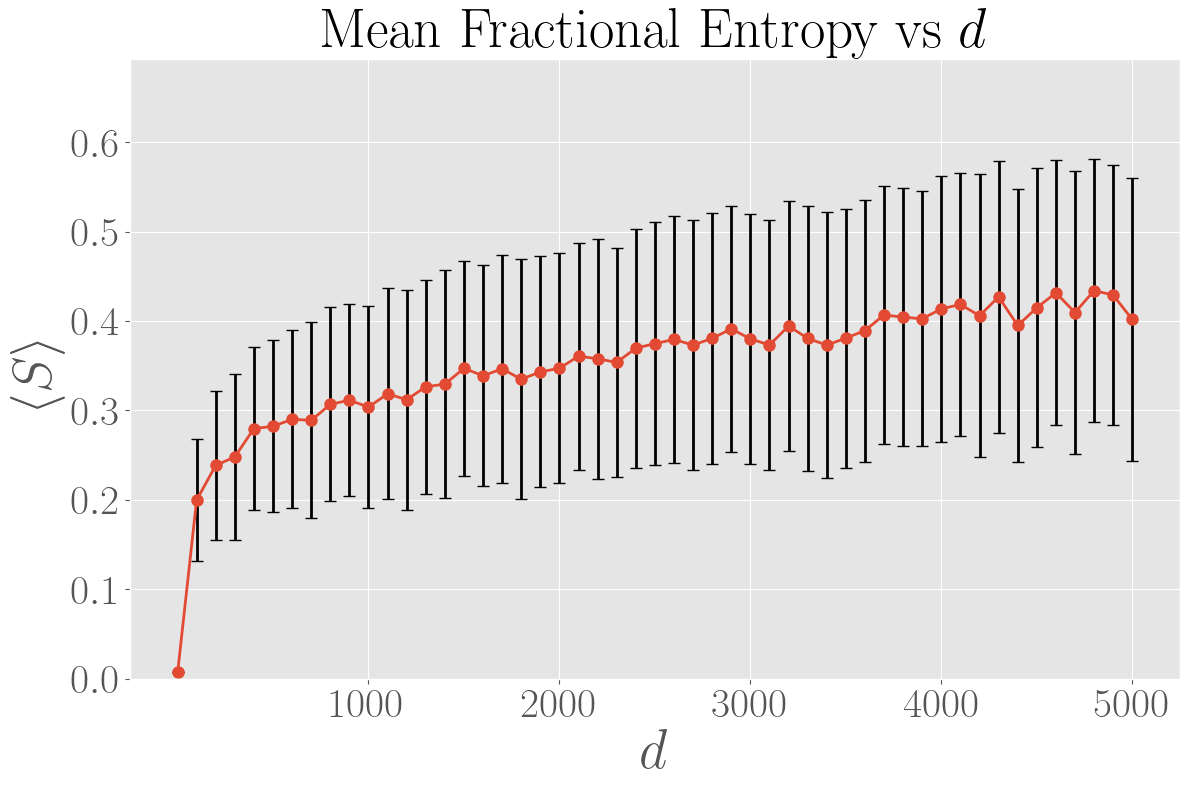

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration (Replace these with your actual data)
# x = [1] + list(range(100, 5001, 100))
# mean_entmean = np.random.rand(len(x))  # Replace with your actual mean data
# std_entmean = np.random.rand(len(x)) * 0.1  # Replace with your actual std deviation data


# Use a context manager to apply rc settings temporarily
with plt.rc_context({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 24,  # Base font size
    'axes.titlesize': 30,
    'axes.labelsize': 30,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'lines.markersize': 8,
    'lines.linewidth': 2,
    'errorbar.capsize': 4,
    #'errorbar.elinewidth': 2,
    'figure.figsize': (12, 8),  # Width, Height in inches
}):
    plt.style.use('ggplot')  # Apply a clean style with grid

    fig, ax = plt.subplots()

    # Plot with error bars
    ax.errorbar(
        x, 
        mean_entmean, 
        yerr=std_entmean, 
        fmt='-o',                    # Line with circle markers
        ecolor='black',         # Color of the error bars
        capsize=4,                  # Size of the caps on the error bars
        label=r'Mean Frac. Entropy' # LaTeX-rendered label
    )

    # Labels and Title
    ax.set_xlabel(r"$d$",fontsize=40)
    ax.set_ylabel(r'$\langle S \rangle$',fontsize=40)
    ax.set_title(r'Mean Fractional Entropy vs $d$',fontsize=40)

    # Set x-ticks every 1000 up to 5000, including the first point if needed
    tick_positions = [0] + list(range(1000, 5001, 1000))
    # Ensure 0 is within the x range
    tick_positions = [tick for tick in tick_positions if min(x) <= tick <= max(x)]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([str(tick) for tick in tick_positions])

    # Optionally, set y-limits for better visualization
    ax.set_ylim(bottom=0, top=max(mean_entmean) + max(std_entmean) + 0.1)

    # Add legend if there are multiple datasets
    #ax.legend(fontsize=24)

    # Optimize layout
    plt.tight_layout()

    # Save the figure
    plt.savefig(
        r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\Misc. Plots\mean_fractional.pdf',
        dpi=600,
        bbox_inches='tight',
        transparent=False,
        format='pdf'
    )

    # Display the plot
    plt.show()


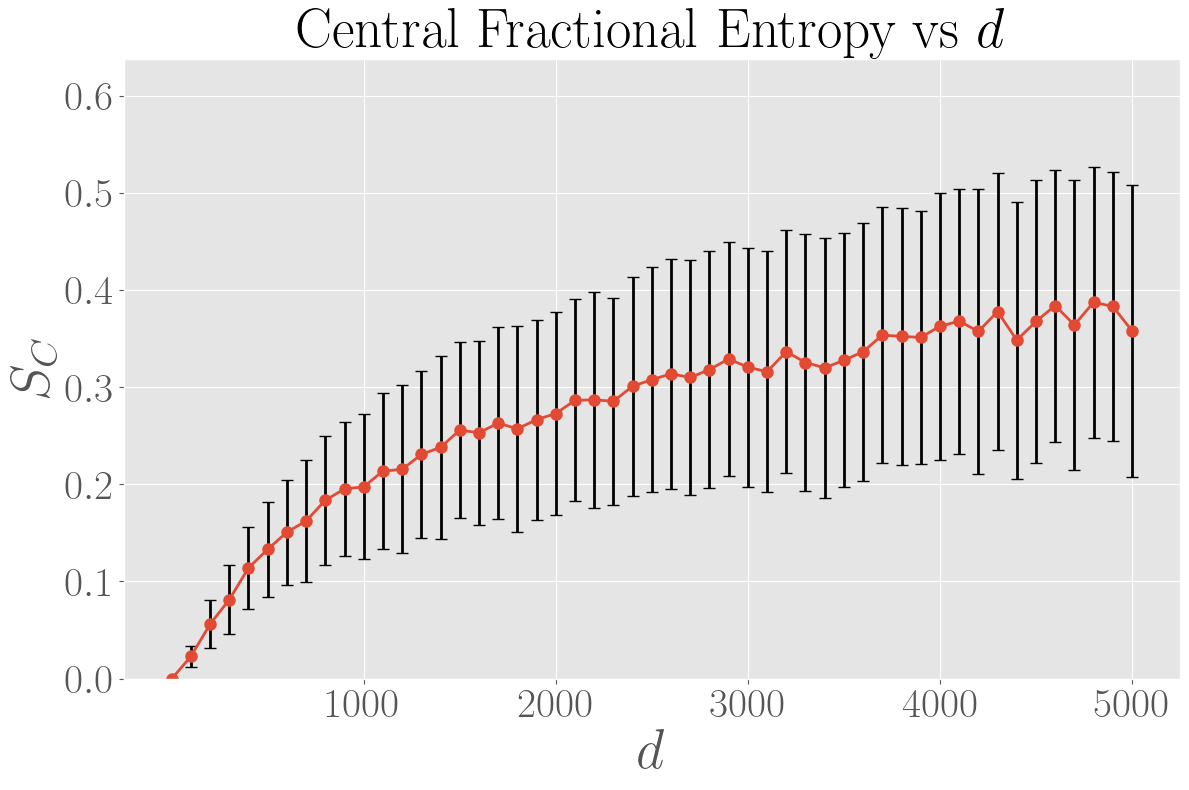

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration (Replace these with your actual data)
# x = [1] + list(range(100, 5001, 100))
# mean_entmean = np.random.rand(len(x))  # Replace with your actual mean data
# std_entmean = np.random.rand(len(x)) * 0.1  # Replace with your actual std deviation data


# Use a context manager to apply rc settings temporarily
with plt.rc_context({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 24,  # Base font size
    'axes.titlesize': 30,
    'axes.labelsize': 30,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'lines.markersize': 8,
    'lines.linewidth': 2,
    'errorbar.capsize': 4,
    #'errorbar.elinewidth': 2,
    'figure.figsize': (12, 8),  # Width, Height in inches
}):
    plt.style.use('ggplot')  # Apply a clean style with grid

    fig, ax = plt.subplots()

    # Plot with error bars
    ax.errorbar(
        x, 
        mean_entcent, 
        yerr=std_entcent, 
        fmt='-o',                    # Line with circle markers
        ecolor='black',         # Color of the error bars
        capsize=4,                  # Size of the caps on the error bars
        label=r'Mean Frac. Entropy' # LaTeX-rendered label
    )

    # Labels and Title
    ax.set_xlabel(r"$d$",fontsize=40)
    ax.set_ylabel(r'$S_C$',fontsize=40)
    ax.set_title(r'Central Fractional Entropy vs $d$',fontsize=40)

    # Set x-ticks every 1000 up to 5000, including the first point if needed
    tick_positions = [0] + list(range(1000, 5001, 1000))
    # Ensure 0 is within the x range
    tick_positions = [tick for tick in tick_positions if min(x) <= tick <= max(x)]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([str(tick) for tick in tick_positions])

    # Optionally, set y-limits for better visualization
    ax.set_ylim(bottom=0, top=max(mean_entcent) + max(std_entcent) + 0.1)

    # Add legend if there are multiple datasets
    #ax.legend(fontsize=24)

    # Optimize layout
    plt.tight_layout()

    # Save the figure
    plt.savefig(
        r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\Misc. Plots\central_fractional.pdf',
        dpi=600,
        bbox_inches='tight',
        transparent=False,
        format='pdf'
    )

    # Display the plot
    plt.show()


Experimentation with Chebyshev Polynomials and Random State Vectors

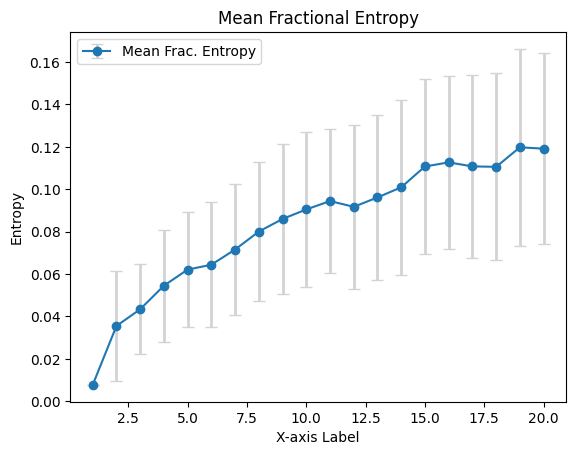

In [69]:
x = list(range(1,21))


plt.errorbar(
    x, 
    mean_entmean, 
    yerr=std_entmean, 
    fmt='-o',                    # Line with circle markers
    ecolor='lightgray',         # Color of the error bars
    elinewidth=2,               # Width of the error bars
    capsize=4,                  # Size of the caps on the error bars
    label='Mean Frac. Entropy'
)


# Labels and Title
plt.xlabel('X-axis Label')
plt.ylabel('Entropy')
plt.title('Mean Fractional Entropy')

# Legend
plt.legend()

# Show Plot
plt.show()

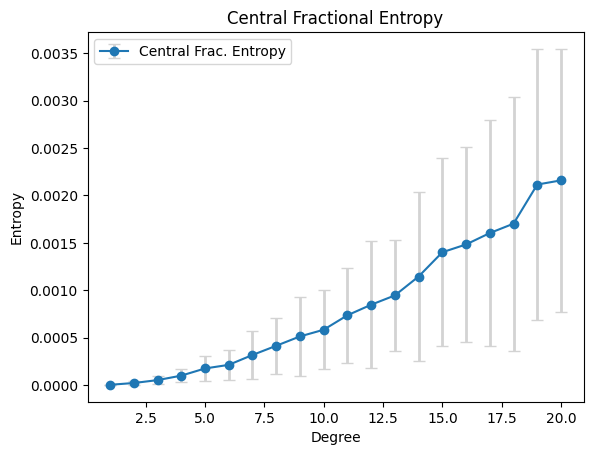

In [67]:
plt.errorbar(
    x, 
    mean_entcent, 
    yerr=std_entcent, 
    fmt='-o',                    # Line with circle markers
    ecolor='lightgray',         # Color of the error bars
    elinewidth=2,               # Width of the error bars
    capsize=4,                  # Size of the caps on the error bars
    label='Central Frac. Entropy'
)

# Labels and Title
plt.xlabel('Degree')
plt.ylabel('Entropy')
plt.title('Central Fractional Entropy')

# Legend
plt.legend()

# Show Plot
plt.show()

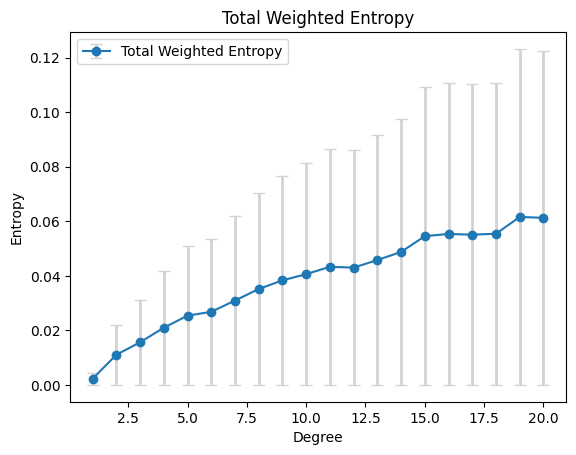

In [91]:
plt.errorbar(
    x, 
    mean_entw, 
    yerr=std_entw, 
    fmt='-o',                    # Line with circle markers
    ecolor='lightgray',         # Color of the error bars
    elinewidth=2,               # Width of the error bars
    capsize=4,                  # Size of the caps on the error bars
    label='Total Weighted Entropy'
)

# Labels and Title
plt.xlabel('Degree')
plt.ylabel('Entropy')
plt.title('Total Weighted Entropy')

# Legend
plt.legend()

# Show Plot
plt.show()

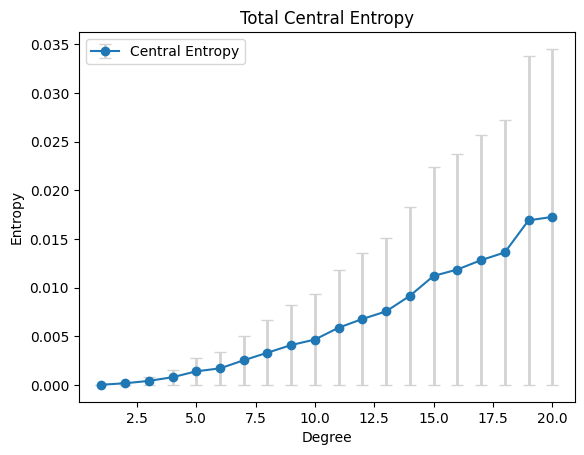

In [89]:
plt.errorbar(
    x, 
    mean_newc, 
    yerr=std_newc, 
    fmt='-o',                    # Line with circle markers
    ecolor='lightgray',         # Color of the error bars
    elinewidth=2,               # Width of the error bars
    capsize=4,                  # Size of the caps on the error bars
    label='Central Entropy'
)

# Labels and Title
plt.xlabel('Degree')
plt.ylabel('Entropy')
plt.title('Total Central Entropy')

# Legend
plt.legend()

# Show Plot
plt.show()

In [150]:
def plot_schmidt_spectrum(y_amp):
        # Calculate number of qubits
    num_qubits = np.log2(y_amp.shape[0])
    assert np.isclose(num_qubits, int(num_qubits)), "Length of y_amp should be a power of 2."
    num_qubits = int(num_qubits)

    # Ensure the number of qubits is even
    assert num_qubits % 2 == 0, "Number of qubits must be even."

    # Define the central bipartition
    central_bond = num_qubits // 2  # Split after central_bond qubits

    # Reshape the amplitude array to separate the two halves
    yamp_unfolded = np.reshape(y_amp, (2**central_bond, 2**central_bond), order='C')

    # Compute Schmidt coefficients via SVD
    singular_values = np.linalg.svd(yamp_unfolded, compute_uv=False)
    s_squared = np.abs(singular_values)**2
    s_squared /= np.sum(s_squared)
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(s_squared, 'o-')
    plt.yscale('log')
    plt.xlabel('Schmidt Coefficient Index')
    plt.ylabel('$\lambda_i^2$')
    plt.title('Schmidt Spectrum')
    plt.grid(True)
    plt.show()

Schmidt Decomposition Functionality

In [321]:
from scipy.optimize import curve_fit

def plot_schmidt_spectrum_with_fit(y_amp, threshold=1e-6, plot_fit=True):
    """
    Plots the Schmidt spectrum and fits an exponential decay curve to the
    singular values above a specified threshold. Returns the fit parameters
    and R^2 value.
    
    Parameters
    ----------
    y_amp : np.ndarray
        Array of amplitudes. Must be 1-D and normalized.
    threshold : float, optional
        Minimum value of Schmidt coefficients to include in the fit.
    plot_fit : bool, optional
        Whether to plot the fitted exponential curve.
        
    Returns
    -------
    popt : tuple
        Optimal values for the exponential decay parameters (A, k).
    r_squared : float
        Coefficient of determination for the fit.
    """
    # Validate input is a 1-D array
    assert y_amp.ndim == 1, "y_amp should be a 1-D array."
    
    # Normalize the quantum state
    norm = np.linalg.norm(y_amp)
    assert norm > 0, "The amplitude array must not be all zeros."
    y_amp = y_amp / norm
    
    # Calculate number of qubits
    num_qubits = np.log2(y_amp.shape[0])
    assert np.isclose(num_qubits, int(num_qubits)), "Length of y_amp should be a power of 2."
    num_qubits = int(num_qubits)
    
    # Ensure the number of qubits is even
    assert num_qubits % 2 == 0, "Number of qubits must be even."
    
    # Define the central bipartition
    central_bond = num_qubits // 2  # Split after central_bond qubits
    
    # Reshape the amplitude array to separate the two halves using C-order
    yamp_unfolded = np.reshape(y_amp, (2**central_bond, 2**central_bond), order='C')
    
    # Compute Schmidt coefficients via Singular Value Decomposition (SVD)
    singular_values = np.linalg.svd(yamp_unfolded, compute_uv=False)
    s_squared = np.abs(singular_values)**2
    s_squared /= np.sum(s_squared)
    
    # Apply threshold
    significant_indices = np.where(s_squared > threshold)[0]
    s_squared_filtered = s_squared[significant_indices]
    indices_filtered = significant_indices
    
    # Define exponential decay function
    def exponential_decay(x, A, k):
        return A * np.exp(-k * x)
    
    # Initial guess for A and k
    A_initial = s_squared_filtered[0]
    k_initial = 1.0
    initial_guess = [A_initial, k_initial]
    
    # Fit the exponential decay to the filtered data
    try:
        popt, pcov = curve_fit(exponential_decay, indices_filtered, s_squared_filtered, p0=initial_guess, maxfev=10000)
    except RuntimeError:
        print("Exponential fit did not converge.")
        popt = [np.nan, np.nan]
        r_squared = np.nan
        if plot_fit:
            plt.figure(figsize=(8, 5))
            plt.plot(s_squared, 'o-', label='Schmidt Coefficients')
            plt.yscale('log')
            plt.xlabel('Schmidt Coefficient Index')
            plt.ylabel('$\lambda_i^2$')
            plt.title('Schmidt Spectrum')
            plt.grid(True)
            plt.legend()
            plt.show()
        return popt, r_squared
    
    # Compute fitted values
    fitted_values = exponential_decay(indices_filtered, *popt)
    
    # Calculate R^2
    residuals = s_squared_filtered - fitted_values
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((s_squared_filtered - np.mean(s_squared_filtered))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Plot the Schmidt spectrum and the fit
    plt.figure(figsize=(10, 6))
    plt.plot(s_squared, 'o-', label='Schmidt Coefficients')
    if plot_fit:
        plt.plot(indices_filtered, fitted_values, 'r--', label=f'Exponential Fit: A={popt[0]:.2e}, k={popt[1]:.2f}')
    plt.yscale('log')
    plt.xlabel('Schmidt Coefficient Index')
    plt.ylabel('$\lambda_i^2$')
    plt.title('Schmidt Spectrum with Exponential Fit')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print(f"Exponential Fit Parameters:\nA = {popt[0]:.4e}\nk = {popt[1]:.4f}\nR² = {r_squared:.4f}")
    
    return popt, r_squared

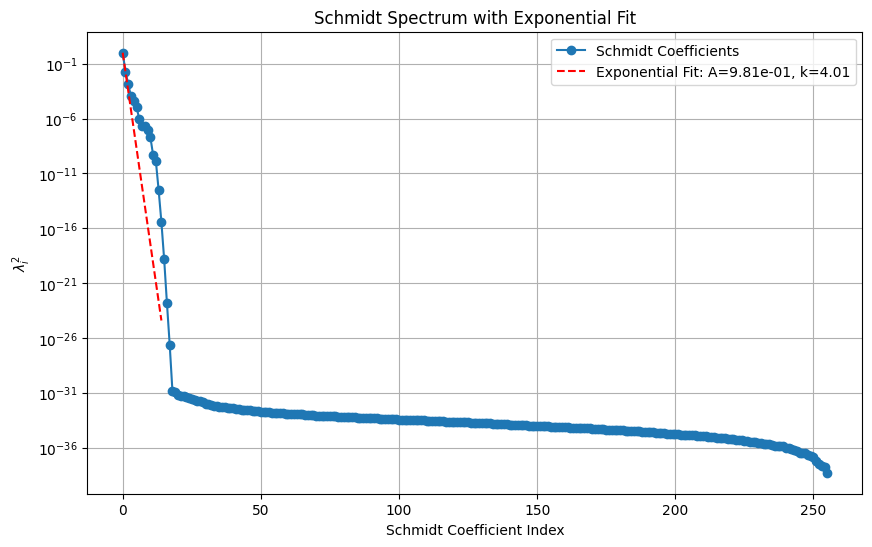

Exponential Fit Parameters:
A = 9.8082e-01
k = 4.0105
R² = 1.0000


(array([0.98081993, 4.01048149]), 0.9999989602401543)

In [333]:
f = generate_piecewise_chebyshev((-1,1),10,10)
x_vals = np.linspace(-1,1,2**16)
f_vals = f(x_vals)
f_vals = f_vals / np.linalg.norm(f_vals)

plot_schmidt_spectrum_with_fit(f_vals,threshold=1e-16)

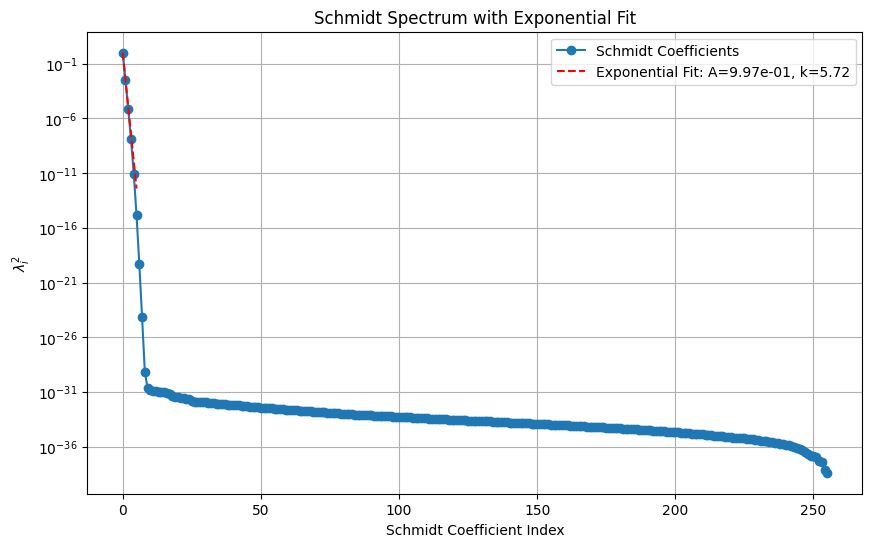

Exponential Fit Parameters:
A = 9.9671e-01
k = 5.7155
R² = 1.0000


(array([0.996709  , 5.71550441]), 0.9999999999851912)

In [325]:
f = generate_piecewise_chebyshev((-1,1),1,20)
x_vals = np.linspace(-1,1,2**16)
f_vals = f(x_vals)
f_vals = f_vals / np.linalg.norm(f_vals)

plot_schmidt_spectrum_with_fit(f_vals,threshold=1e-16)

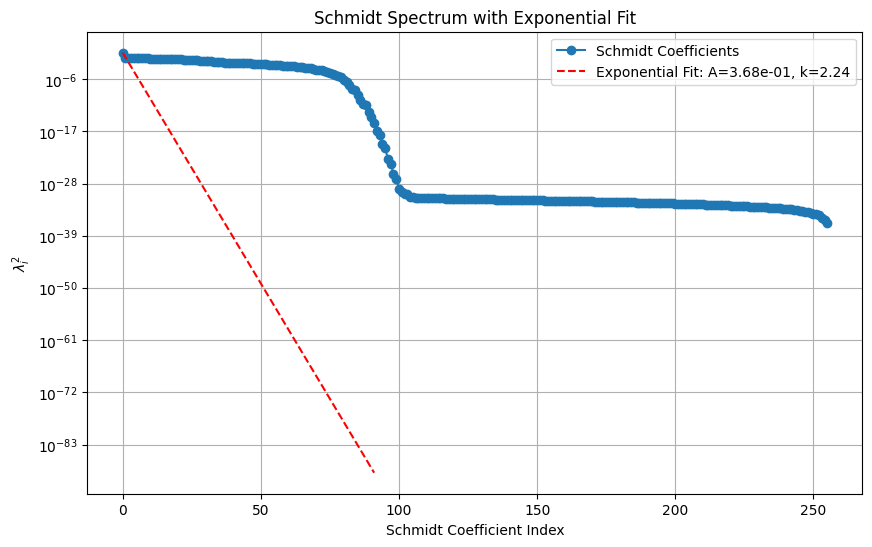

Exponential Fit Parameters:
A = 3.6841e-01
k = 2.2391
R² = 0.9202


(array([0.3684086 , 2.23912346]), 0.9201517799739715)

In [330]:
f = generate_piecewise_chebyshev((-1,1),1,10000)
x_vals = np.linspace(-1,1,2**16)
f_vals = f(x_vals)
f_vals = f_vals / np.linalg.norm(f_vals)

plot_schmidt_spectrum_with_fit(f_vals,threshold=1e-16)

In [318]:
def required_bond_dimension(y_amp, threshold=1e-17):
    y_amp = y_amp / np.linalg.norm(y_amp)
    num_qubits = int(np.log2(y_amp.size))
    central_bond = num_qubits // 2
    yamp_unfolded = y_amp.reshape((2**central_bond, 2**central_bond), order='C')
    singular_values = np.linalg.svd(yamp_unfolded, compute_uv=False)
    s_squared = np.abs(singular_values)**2
    s_squared /= np.sum(s_squared)
    
    # Cumulative sum
    cumulative = np.cumsum(s_squared)
    
    # Find the smallest chi such that cumulative >= 1 - threshold
    chi = np.searchsorted(cumulative, 1 - threshold) + 1
    return chi

In [319]:
f = generate_piecewise_chebyshev((-1,1),1,100)
x_vals = np.linspace(-1,1,2**16)
f_vals = f(x_vals)
f_vals = f_vals / np.linalg.norm(f_vals)

print(required_bond_dimension(f_vals))

10


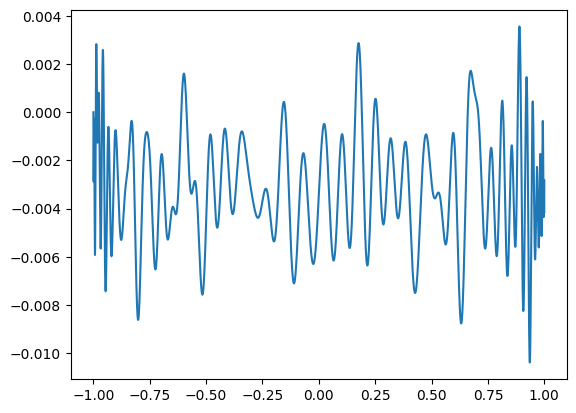

In [320]:
plt.plot(x_vals, f_vals)

Random State Vector Entropies

In [94]:
ents_m = []
ents_c = []
ents_w = []
ents_newc = []
for j in range(200):
    f = generate_random_n_qubit_state(16)
    ents_m.append(mean_fractional_entropy(f))
    ents_c.append(central_fractional_entropy(f))
    ents_w.append(weighted_total_entropy(f))
    ents_newc.append(central_entropy(f))

print(np.mean(ents_m))
print(np.std(ents_m))

print(np.mean(ents_c))
print(np.std(ents_c))

print(np.mean(ents_w))
print(np.std(ents_w))

print(np.mean(ents_newc))
print(np.std(ents_newc))

0.9890256303586321
9.511974651214136e-05
0.9095121398683292
0.0005263090646887858
0.9810915351606875
0.0001529482265999667
7.276097118946634
0.004210472517510286


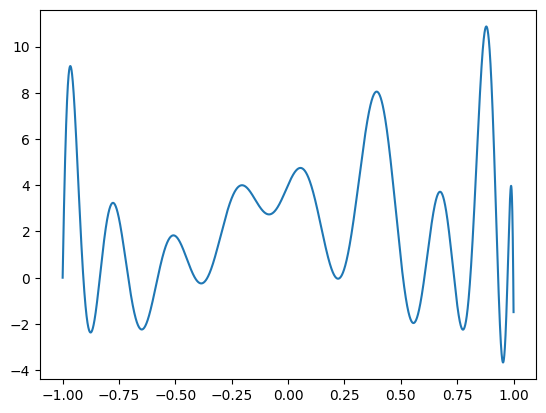

In [127]:
f = generate_piecewise_chebyshev((-1,1),1,20)

x_vals = np.linspace(-1,1,2**16)

f_vals = f(x_vals)

plt.plot(x_vals, f_vals)